In [576]:
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Introduction

## Motivation for the Project

The quality of wine significantly impacts its market value and consumer satisfaction. With the global wine industry growing rapidly, identifying the key factors that influence wine quality has become essential for producers, marketers, and connoisseurs. Leveraging data science and machine learning techniques provides an opportunity to gain insights into these factors and predict wine quality effectively.

This project aims to analyze a dataset containing various physicochemical properties of wines to understand how they relate to quality. By exploring the data and building predictive models, we can determine the most critical features influencing wine quality and make data-driven recommendations for improvement.

---

## Data Overview

The dataset used in this analysis contains **1,143 rows** and **13 columns**, representing the chemical composition and quality ratings of different wines. The key features include:

- Physicochemical properties such as acidity, pH, alcohol content, and sugar levels.
- Quality ratings provided on a scale from 3 to 8 (low to high quality).

The data was processed and analyzed using Python libraries such as **Pandas**, **Matplotlib**, **Seaborn**, and **Scikit-learn**, along with SQL database operations using **SQLAlchemy**. Data exploration, visualization, and predictive modeling are conducted to derive meaningful insights.

---

## Benefits of the Analysis

1. **Wine Producers**: Insights into which chemical properties most significantly influence wine quality can help optimize production processes and improve the product.
2. **Consumers**: Consumers can better understand what factors contribute to high-quality wine, leading to more informed purchasing decisions.
3. **Industry Standards**: Establishing data-driven benchmarks for wine quality can improve overall industry practices and consumer trust.

---

## Purpose of the Analysis

The primary objectives of this project are as follows:

1. **Exploratory Data Analysis (EDA)**: Understand the distribution of wine quality and the relationships between physicochemical properties.
2. **Feature Analysis**: Identify the most significant factors affecting wine quality through correlation, feature importance, and principal component analysis (PCA).
3. **Predictive Modeling**: Build machine learning models to classify wine quality and compare their performance.
4. **Practical Applications**: Provide actionable insights for stakeholders in the wine industry based on data-driven conclusions.

Through these objective, we try to answer the following questions relevant to the stakeholders:
1. What are the properties of a wine and which of them are relevant for quality determination?
2. Which properties of wine are most important to improve the quality of a wine?
3. Which properties of wine have most adverse affect on the quality of a wine?
4. What recommendations can we give to the stakeholders in order to improve their wine quality?
5. Given the properties of a same wine, what can be say about its quality? We try to answer this by predictive modelling.

This analysis integrates statistical techniques, machine learning models, and advanced visualization to ensure comprehensive and interpretable results. Through this work, we aim to bridge the gap between traditional winemaking practices and modern data science methodologies.

# Data Analysis

## Load data using pandas

In [577]:
df = pd.read_csv('/Users/nitinnandansingh/Documents/workspace/Wine-Quality-Analysis/Assets/WineQT.csv')
print(df.shape)
df.head(3)

(1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2


## Store dataframe in database and load

* In this section, we will store the dataframe in the in-memory database and perform simple queries. This is done to show profiency in sql.

In [578]:
engine = create_engine("sqlite:///:memory:")
df.to_sql("winedb", engine, index=False, if_exists="replace")

1143

* `sqlalchemy` is a Python library used for SQL database interactions. It provides tools for connecting to databases and running SQL queries.

* `create_engine` is a function to establish a connection to a database. This is the primary interface between SQLAlchemy and the database.

* `sqlite:///:memory:` - This specifies an in-memory SQLite database.

* `sqlite://` specifies that we are using SQLite as the database system.

* `:memory:` indicates the database is temporary and exists only in RAM during the session.
	
* `engine` acts as the connection object to interact with the database.

In [579]:
query = "Select * from winedb limit 3"
result = pd.read_sql(query, engine)
result

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2


Here we query first 3 rows of the database using the constructed sql query. It can be seen that the rows match those returned by the pandas `head` function.

In [580]:
query = "Select count(*) as quality_more_than_eight from winedb where quality>=8"
result = pd.read_sql(query, engine)
result

,quality_more_than_eight
0,16


Here we output the number of rows in the database where the quality of wines is greater than or equal to 8

In [581]:
query = "Select quality, count(*) as number_of_wines from winedb group by quality order by quality"
result = pd.read_sql(query, engine)
result

,quality,number_of_wines
0,3,6
1,4,33
2,5,483
3,6,462
4,7,143
5,8,16


Here we use group by clause to group the wines based on quality measures.

## Explore data

* From here on, I will stick to using python and python specific libraries for analysis

In [582]:
print(df.shape)
df.head(10)

(1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,6
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,8
9,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5,10


There are 1143 rows in the dataset with all column values in floating point except for `quality` and `id` which have integer values.

In [583]:
print(len(df.columns.to_list()))
df.columns.to_list()

13


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'Id']

Let's look at the columns available in the dataframe. There are 13 columns as listed above.

In [584]:
df.describe(include='all').fillna('')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


Using `describe` function, I get some basic statistics about the data. I am interested in knowing the min, max and mean values of different features.

In [585]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [586]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

We can see that there are no null values in the dataset.

In [587]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(1143, 13)

There are no duplicates in the dataset to remove.

### Explore Outliers

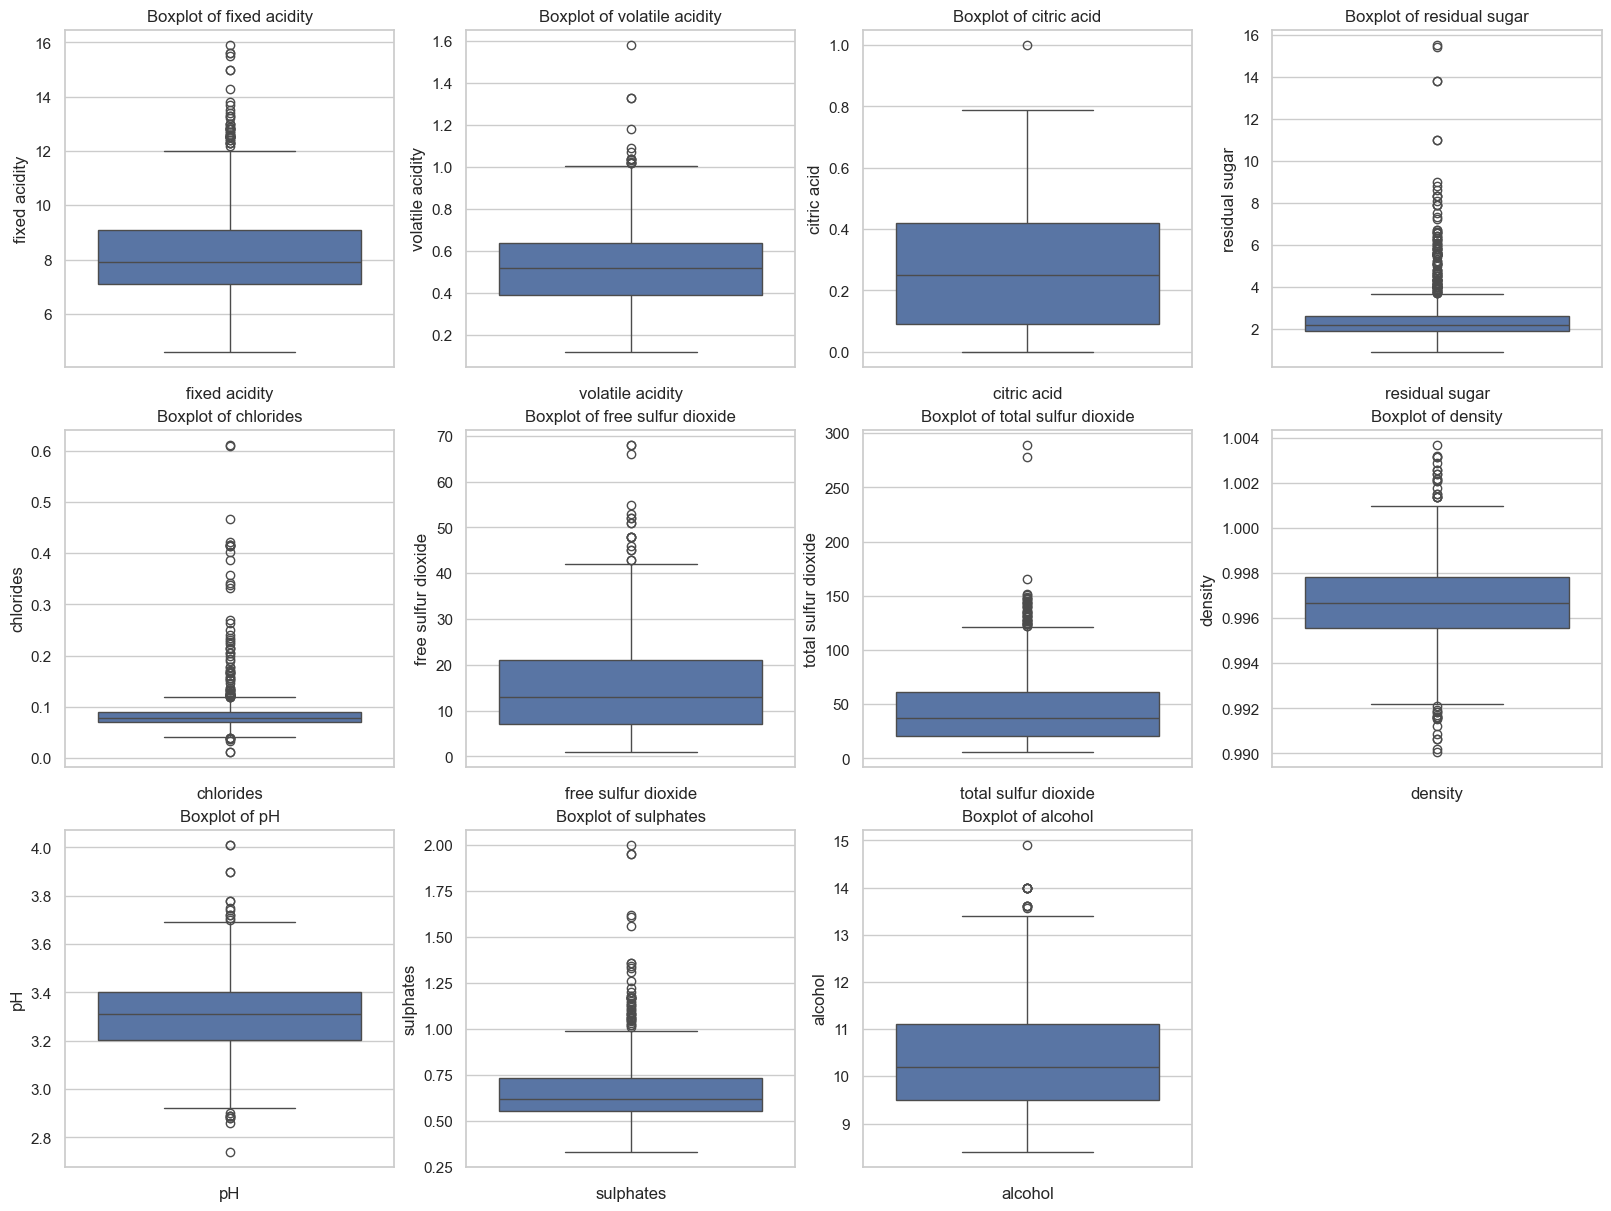

In [588]:
# Columns to plot: Excluding Id and Quality
numeric_columns = [col for col in df.select_dtypes(include=np.number).columns if col not in ['Id', 'quality']]

# Grid dimensions
n_cols = 4
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

# Create the grid of boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows), constrained_layout=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot each column
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()

In [589]:
# Dictionary to store outlier information
outliers_info = {}

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)  # First quartile
    Q3 = df[col].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range

    # Determine outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_info[col] = len(outliers)

In [590]:
print("Number of outliers detected and handled per column:")
for col, count in outliers_info.items():
    print(f"{col}: {count} outliers")

Number of outliers detected and handled per column:
fixed acidity: 44 outliers
volatile acidity: 14 outliers
citric acid: 1 outliers
residual sugar: 110 outliers
chlorides: 77 outliers
free sulfur dioxide: 18 outliers
total sulfur dioxide: 40 outliers
density: 36 outliers
pH: 20 outliers
sulphates: 43 outliers
alcohol: 12 outliers


We can see that there are many outliers in each column. For descriptive statistical analysis we will not remove them but will fix them before performing predictive analysis.

In [591]:
df.shape

(1143, 13)

### Quality Counts

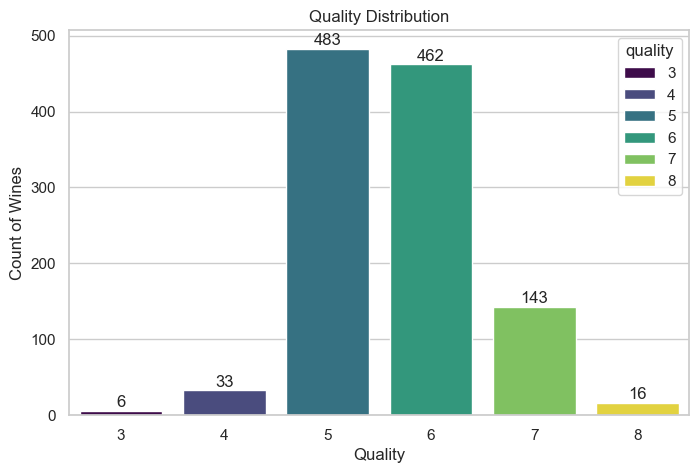

In [592]:
# Number of wines per quality category

# Create the countplot
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='quality', palette='viridis', hue='quality')

# Get the count for each quality
counts = df['quality'].value_counts().sort_index()

# Add the count labels on top of each bar
for i, count in enumerate(counts):
    ax.text(i, count + 5,
            str(count),
            ha='center', fontsize=12)

plt.title('Quality Distribution')
plt.xlabel('Quality')
plt.ylabel('Count of Wines')
plt.show()

In this plot we can see that most of the wines have been given the rating of 5 or 6. This implies that majority of wines have been classified to be of low or average quality. We can also observe that the dataset doesn't represent each classify equally, there many record for quality 5 as compared to quality 8 or 3.

### Correlation Analysis

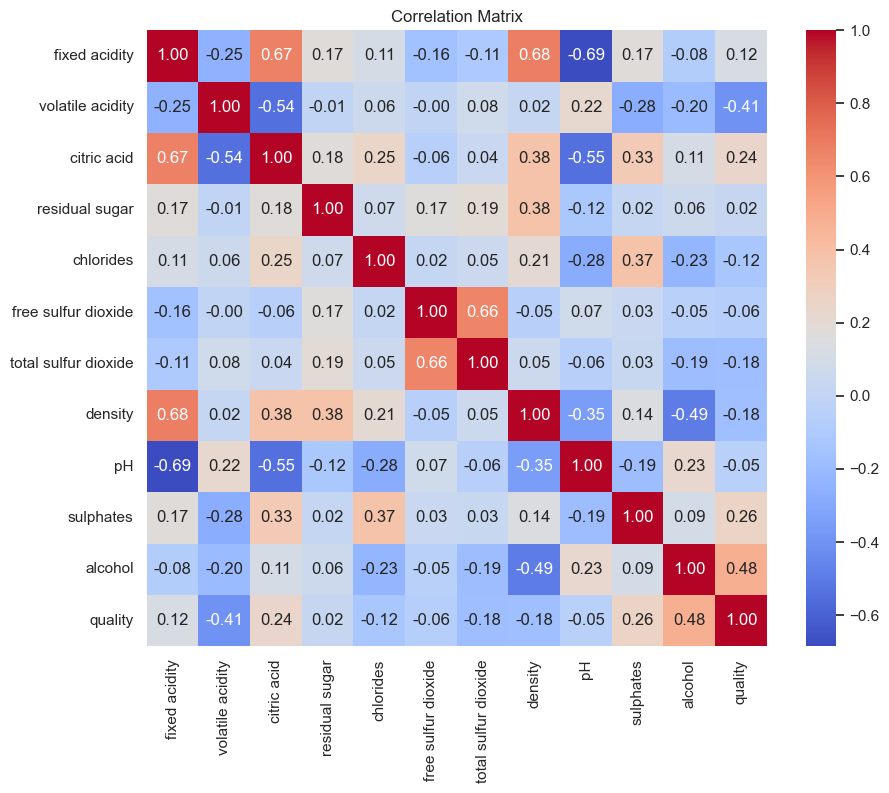

In [593]:
# Remove id column which is irrelevant column for this analysis
df.drop(columns=['Id'], inplace=True)

correlation_matrix = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [594]:
quality_correlation = correlation_matrix['quality'].sort_values(ascending=False)
print("Correlation with quality:\n", quality_correlation)

Correlation with quality:
 quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64


In [595]:
# Save the correlation data for PowerBI
quality_correlation_df = pd.DataFrame({
    'features': quality_correlation.index,
    'corr': quality_correlation.values
})
quality_correlation_df = quality_correlation_df[1:]
quality_correlation_df.to_csv('/Users/nitinnandansingh/Documents/workspace/Wine-Quality-Analysis/Assets/quality_corr.csv', index=False)

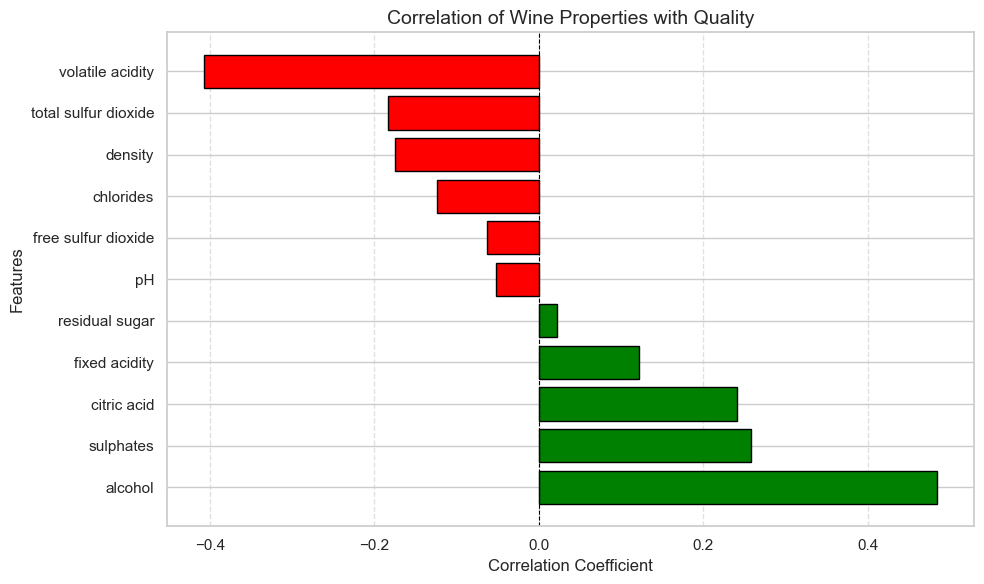

In [596]:
features = quality_correlation.index.to_list()[1:]
values = quality_correlation.values.tolist()[1:]

plt.figure(figsize=(10, 6))
colors = ['green' if corr > 0 else 'red' for corr in values]

plt.barh(features, values, color=colors, edgecolor='black')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Correlation of Wine Properties with Quality', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Properties affecting quality

##### alcohol, sulphates, citric acid:
* Positive correlation with quality.
* Higher alcohol content is associated with better wine quality. This could be due to its impact on taste and overall balance of the wine.
* Sulphates contribute to wine stability and may enhance flavors, positively influencing quality.
* Citric acid affects the wine’s freshness and acidity balance, which improves quality.

##### fixed acidity:
* Weak positive correlation.
* Fixed acids (e.g., tartaric acid) contribute to the structure and balance of wine but have a relatively small impact on quality.

##### residual sugar:
* Almost no correlation with quality.
* While residual sugar contributes to sweetness, it seems to have little impact on the perceived quality of wine.

##### volatile acidity, total sulfur dioxide, density, chlorides, free sulfur dioxide, pH:
* Negative correlation.
* High volatile acidity (acetic acid) leads to undesirable vinegar-like tastes, lowering quality.
* Excess sulfur dioxide can give off unpleasant aromas and affect taste, reducing quality.
* Higher density (often linked to higher sugar levels or lower alcohol) is associated with lower quality.
* High chloride levels indicate saltiness, which negatively affects quality.
* Free sulfur dioxide is necessary for preservation but excessive amounts can negatively impact taste.
* While pH measures acidity, its influence on quality is not as direct or significant as other features.


##### Key Insights

Top Positive Influencers:
* alcohol, sulphates, and citric acid positively affect wine quality. These should be optimized for better quality wine.

Top Negative Influencers:
* volatile acidity has the strongest negative impact on quality. Reducing volatile acidity is critical for improving wine.
* total sulfur dioxide and density also negatively influence quality but to a lesser extent.

Minimal Impact Features:
* residual sugar and pH have negligible linear relationships with quality, meaning they might not significantly impact quality in isolation.

From the above heat map we can conclude that the total sulphur dioxide and free sulphur dioxide are highly correlated features.

### Random Forest Classifier analysis to identify important features

Feature Importance:
                 Feature  Importance
10               alcohol    0.149461
9              sulphates    0.119844
1       volatile acidity    0.105066
6   total sulfur dioxide    0.098538
7                density    0.087432
4              chlorides    0.077277
8                     pH    0.076702
2            citric acid    0.074505
0          fixed acidity    0.073853
5    free sulfur dioxide    0.069832
3         residual sugar    0.067489


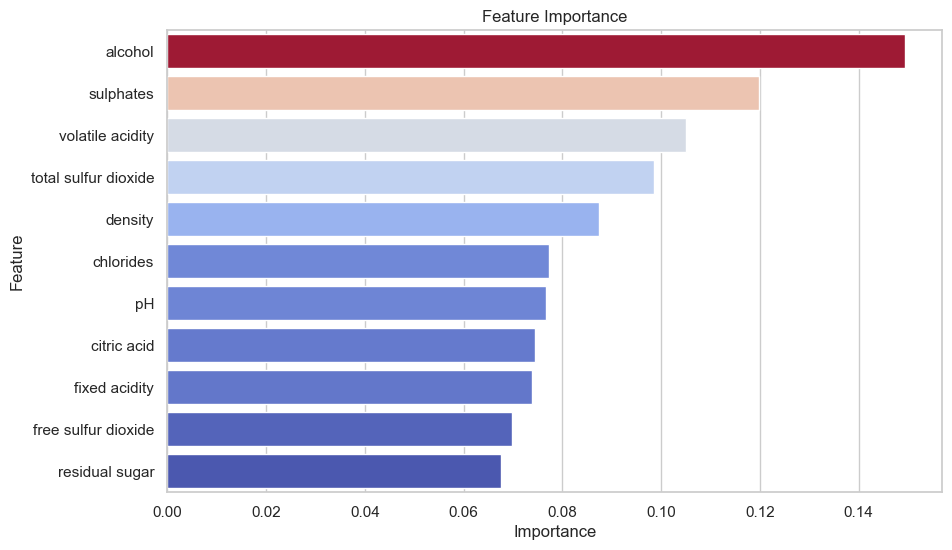

In [597]:
# Prepare data
X = df.drop(columns=['quality'])
y = df['quality']

# Prepare model
model = RandomForestClassifier(random_state=42)

# Fit model on the data
model.fit(X, y)

# Get important features
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importances)

# Plot data
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='coolwarm', hue='Importance', legend=False)
plt.title('Feature Importance')
plt.show()

Key Insights:
* Focusing on optimizing alcohol, sulphates, and volatile acidity could significantly improve wine quality.
* Efforts to manage total sulfur dioxide and density are also worth considering, though their impact is less pronounced.
* Features with lower importance, such as residual sugar and free sulfur dioxide, can be deprioritized for quality improvements.

### PCA analysis

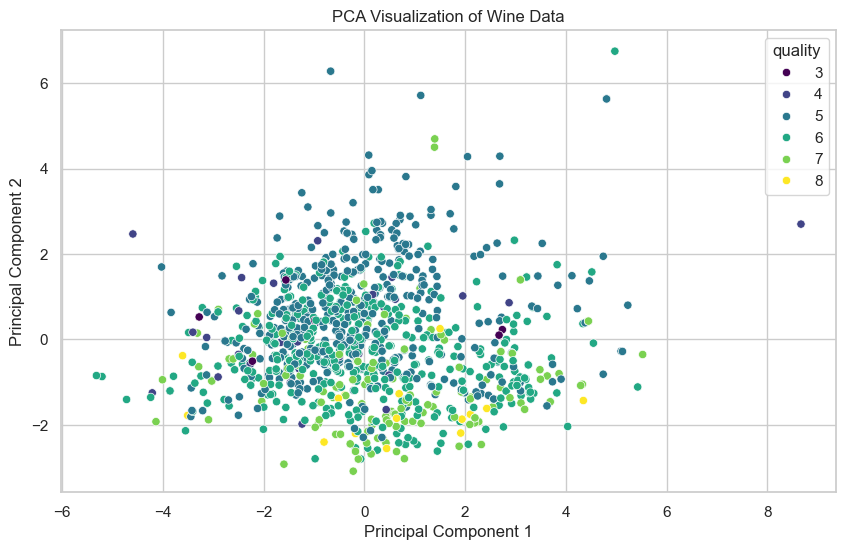

In [598]:
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['quality'], palette='viridis')
plt.title('PCA Visualization of Wine Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

This plot shows the PCA scores for 2 components PC1 and PC2. We can see that the high quality wines are spread along the low PC2 scores (y-axis) and low quality wines are aligned with high PC2 scores. But there is almost no separability between different qualities and hence this suggests that wines with similar quality scores may have similar feature distributions, making it difficult to distinguish them clearly in the reduced 2D space.

Let dig deeper by analysing the laodings values which tells how much do the features influence the PC scores.

In [599]:
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1', 'PC2'])
print("PCA Loadings:")
print(loadings)

PCA Loadings:
                           PC1       PC2
fixed acidity         0.485339 -0.102328
volatile acidity     -0.227143  0.288786
citric acid           0.460075 -0.146508
residual sugar        0.174506  0.252262
chlorides             0.224870  0.153133
free sulfur dioxide  -0.047852  0.517022
total sulfur dioxide  0.015069  0.577393
density               0.399684  0.217537
pH                   -0.432844 -0.006374
sulphates             0.237555 -0.062280
alcohol              -0.118799 -0.381635


#### PCA Loadings Interpretation

The PCA loadings indicate how strongly each original feature contributes to a principal component. Positive or negative values show the direction of the relationship, and the magnitude reflects the strength.

* Each value in the matrix shows the direction and magnitude of the feature’s contribution to the respective component.
* `Positive values`: The feature increases the component score when its value increases.
* `Negative values`: The feature decreases the component score when its value increases.
* `Magnitude (absolute value)`: Indicates the strength of the feature’s contribution.

`PC1 (Primary Component, Largest Variance)`

Dominant Features (highest absolute loadings):
 * fixed acidity (0.485): Major contributor to PC1.
 * citric acid (0.460): Strong positive contribution.
 * density (0.399): Also positively contributes.
 * pH (-0.433): Significant negative contribution.

`Interpretation`

PC1 primarily captures variability related to fixed acidity, citric acid, density, and pH.
Wines with high PC1 scores likely have higher acidity and density but lower pH (since pH contributes negatively).

`PC2 (Secondary Component, Second Largest Variance)`

Dominant Features:
* total sulfur dioxide (0.577): Major positive contributor.
* free sulfur dioxide (0.517): Significant positive contributor.
* volatile acidity (0.289): Also contributes positively.
* alcohol (-0.382): Negative contributor.

`Interpretation`

PC2 mainly represents sulfur dioxide levels (both total and free), along with volatile acidity. Lower PC2 scores might be associated with higher alcohol content. When alcohol value increases PC2 scores decreases. In the PCA plot, we can see that higher quality wines are aligned with low PC2 scores, suggesting high quality wines have higher alcohol content. This matches with our initial analysis using correlation and random forest classifies analysis.



### Box Plot analysis of different feature with quality

/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_22207/1244390889.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


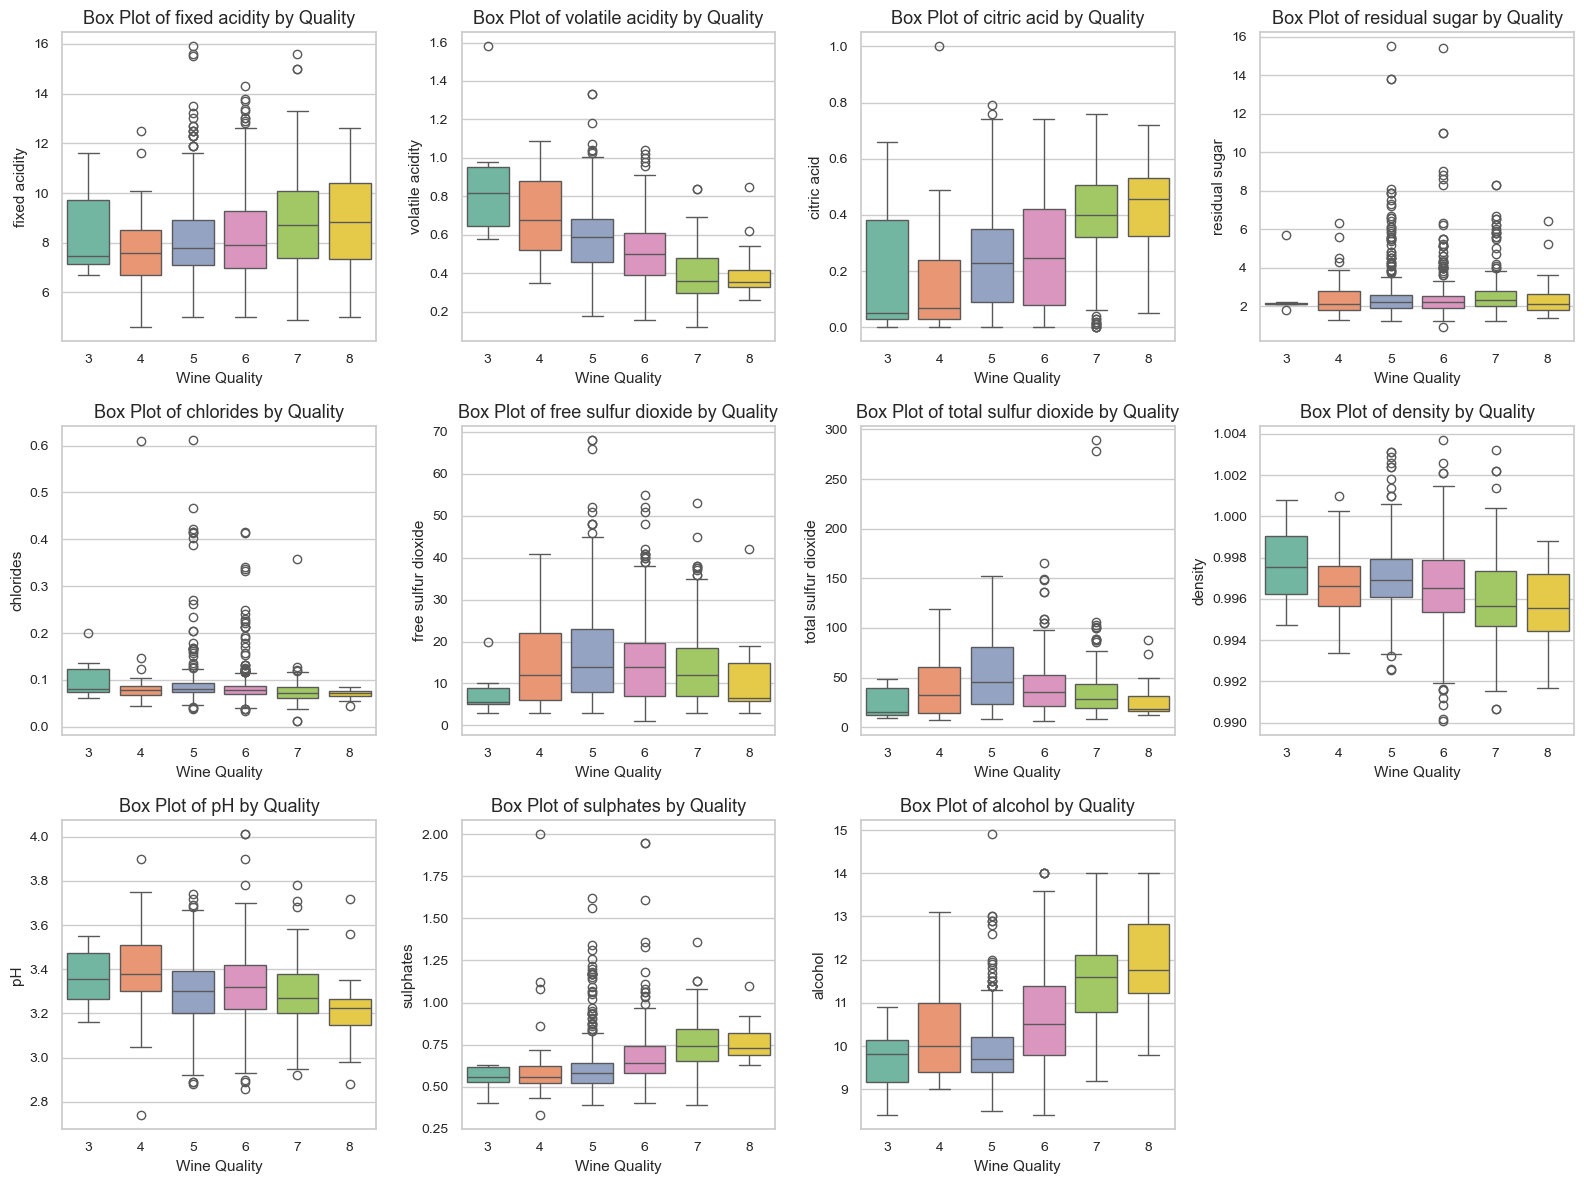

In [600]:
features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
    'pH', 'sulphates', 'alcohol'
]

sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='quality', y=feature, data=df, palette='Set2', hue='quality', ax=axes[i], legend=False)
    axes[i].set_title(f'Box Plot of {feature} by Quality', fontsize=13)
    axes[i].set_xlabel('Wine Quality', fontsize=11)
    axes[i].set_ylabel(feature, fontsize=11)
    axes[i].tick_params(axis='both', labelsize=10)
    
# Hiding unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)    

plt.tight_layout()
plt.legend()
plt.show()

#### Observations

* The fixed acidity has the median value mostly in constant range throughout the wine data, only a bit more in the wines of higher quality.
* We can clearly see that volatile acidity dips with increasing quality of wines. This indicates that highly rated wine have lesser presence of volatile acidity.
*The citric acidity shows a different trend though. In better quality of wines, we see higher presence of citric acidity as compared to those of lower quality.

* Residual Sugar remains mostly constant, indicating that the variation in this feature doesn't impact the quality much.
* The range of Chlorides in wines are narrow, especially for the higher quality wines, showing that to maintain the quality the amount of chlorides need to be in check and in moderation. High level of chlorides can indicate contamination.

* It can be seen that Free Sulphur Dioxide, a chemical used for preserving wines, has a lesser amount in wines of low quality. Also, it should be noted that this preservative needs to be present in moderation because, wines with high range of this chemical can be lower in quality.

* Wines with higher density, often result from higher sugar content and lesser alcohol. Hence, the range of density is lower for qines of higher quality.

* pH denotes acidity at lower values and alkalinity at higher values. Acidity due to citric acid may contribute to the quality of wine but it is not true for volatile acidity. Hence, in the box plot, pH values have higher range for low quality wines.

* For sulphates, we can see a clear upward trend as quality of wines go up, indicating that higher levels of sulphates increase the aroma and flavour.

* For Alcohol as well, we see an upward trend. It matches with our previous analysis that wines with optimum levels of alcohols are highly rated.

/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_22207/1819415712.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'quality_group', y=feature, data=df_categorised, palette='Set2', ax=axes[i])
/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_22207/1819415712.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'quality_group', y=feature, data=df_categorised, palette='Set2', ax=axes[i])
/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_22207/1819415712.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplo

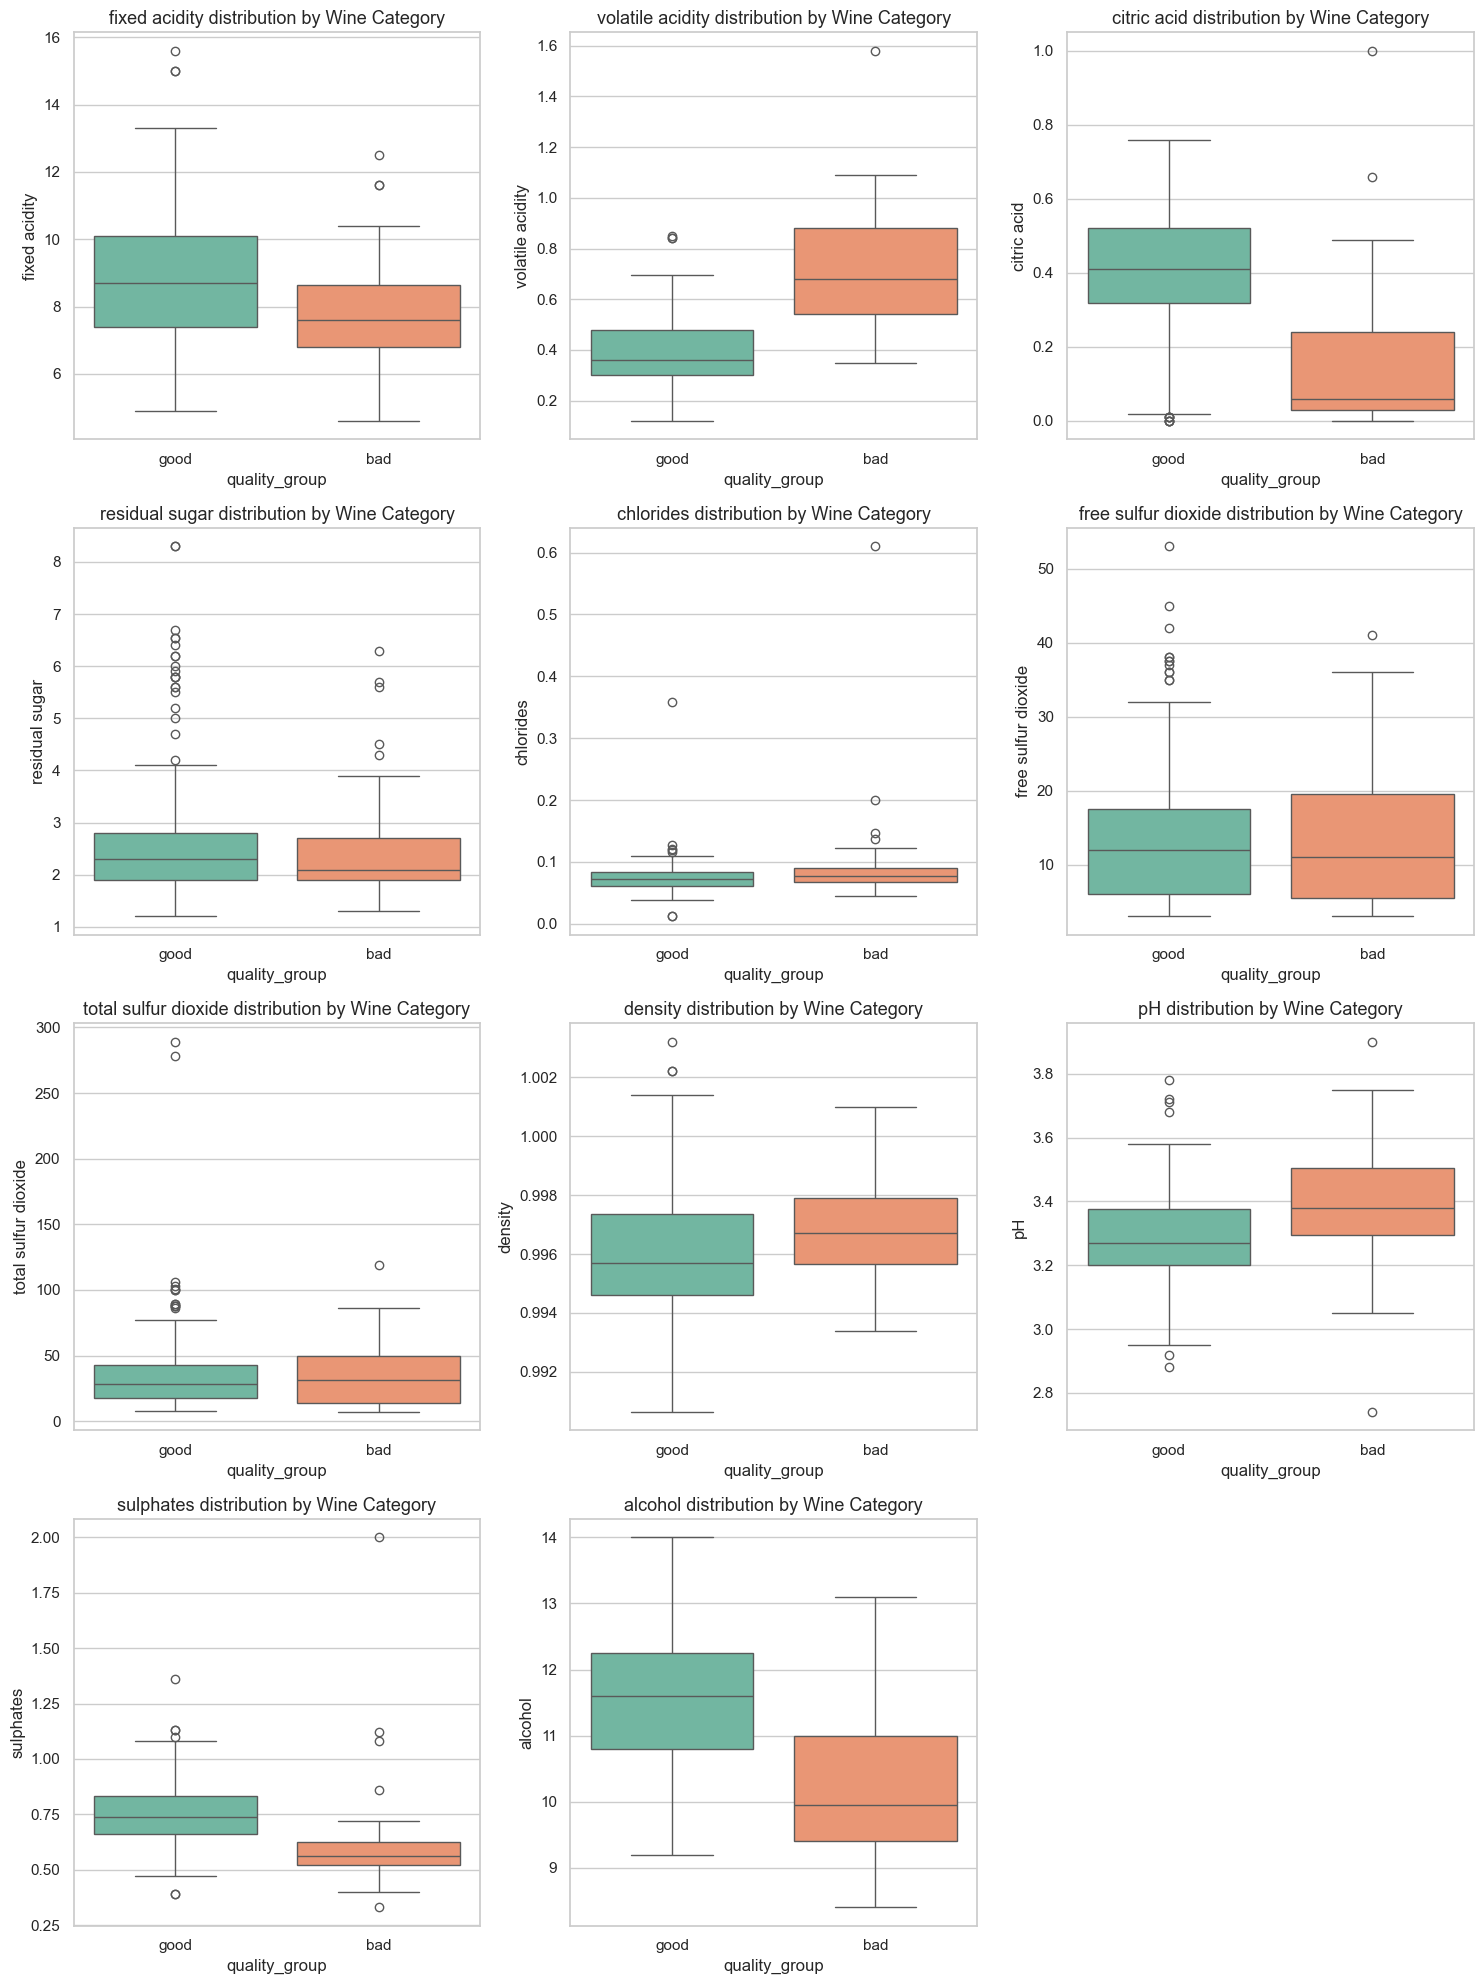

In [601]:
# In this block we will group quality categories into two groups good and bad. Wines with quality 3 and 4 are categorised as bad and those with qualirt 7 and 8 are ctegorised as good.
df_categorised = df.copy()
df_categorised['quality_group'] = df_categorised['quality'].apply(lambda x: 'bad' if x in [3, 4] else ('good' if x in [7, 8] else None))

# Remove rows where 'quality' is neither in the 'bad' nor 'good' groups (quality 5 and 6)
df_categorised = df_categorised[df_categorised['quality_group'].notna()]


properties = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
    'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

# Create a grid of subplots
n_rows = 4
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(properties):
    sns.boxplot(x = 'quality_group', y=feature, data=df_categorised, palette='Set2', ax=axes[i])
    axes[i].set_title(f'{feature} distribution by Wine Category', fontsize=13)
    axes[i].set_ylabel(feature)


# Hiding unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)   
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Our observations here align with the previous observations. Properties such as high values of alcohol, sulphates, citric acid detemine how good the wine is, while attributes such as high pH or high volatile acidity indicate bad quality wines.

### Predictive Modelling

In this section, I will attempt to classify a sample wine into one of the quality values.

For this I will follow following steps:
1. Get to know the data and prepare it for splitting.
2. Split the data into train and test sets and prepare it for modelling.
3. Choose a set of machine learning algorithms to train the data on.
4. Train the data and evaluate the models on test set.
5. Classify a sample wine and assign a quality based on the best model.

In [602]:
df.shape

(1143, 12)

In [603]:
# Fix outliers as it might negatively impact modelling with algorithms such as KNN

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap and floor outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [604]:
df.shape

(1143, 12)

In [605]:

outliers_info = {}

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1 

    # Determine outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_info[col] = len(outliers)

In [606]:
print("Number of outliers detected and handled per column:")
for col, count in outliers_info.items():
    print(f"{col}: {count} outliers")

Number of outliers detected and handled per column:
fixed acidity: 0 outliers
volatile acidity: 0 outliers
citric acid: 0 outliers
residual sugar: 0 outliers
chlorides: 0 outliers
free sulfur dioxide: 0 outliers
total sulfur dioxide: 0 outliers
density: 0 outliers
pH: 0 outliers
sulphates: 0 outliers
alcohol: 0 outliers


In [607]:
df['quality'].value_counts()

quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64

#### Split dependant and independant variables

In [608]:
X = df.drop(columns=['quality']) # Independent variables
y = df['quality'] # Dependent variables

print(X.shape)
print(y.shape)

(1143, 11)
(1143,)


In [609]:
X.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


In [610]:
y.head(3)

0    5
1    5
2    5
Name: quality, dtype: int64

#### Balance the dataset

Class Distribution Before SMOTE:
quality
3      6
4     33
5    483
6    462
7    143
8     16
Name: count, dtype: int64


/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_22207/379398658.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")


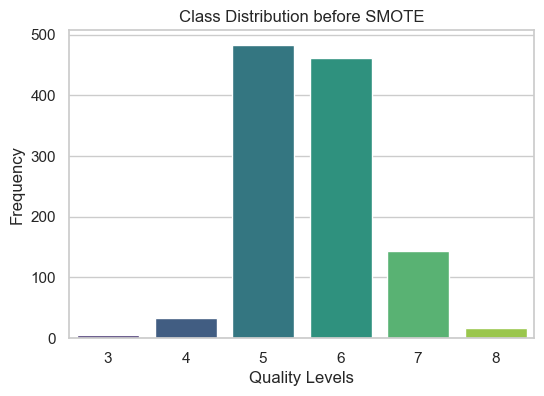

In [611]:
class_distribution = y.value_counts().sort_index()

print("Class Distribution Before SMOTE:")
print(class_distribution)

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Class Distribution before SMOTE")
plt.xlabel("Quality Levels")
plt.ylabel("Frequency")
plt.show()

This dataset needs to be balanced because of imbalanced distribution of different quality wines. This can be done by SMOTE analysis.

In [612]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

print(X.shape)
print(y.shape)

(2898, 11)
(2898,)


Class Distribution After SMOTE:
quality
3    483
4    483
5    483
6    483
7    483
8    483
Name: count, dtype: int64


/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_22207/2076857647.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")


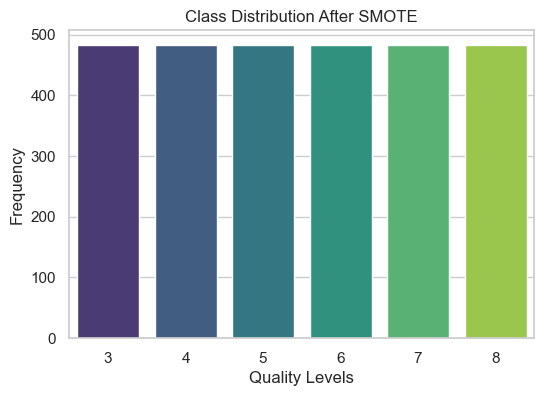

In [613]:
class_distribution = y.value_counts().sort_index()

print("Class Distribution After SMOTE:")
print(class_distribution)

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Quality Levels")
plt.ylabel("Frequency")
plt.show()


#### Create training and test datasets

In [614]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2318, 11) (580, 11)
(2318,) (580,)


#### Standardize the datasets

In [615]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Features are scaled using StandardScaler to improve performance for models like SVM and KNN.

##### Models Used for Wine Quality Classification

##### 1. Logistic Regression
- **What**: Linear model predicting probabilities of different classes using the logistic function.
- **Why**: Simple, interpretable baseline; works well for linear relationships.
- **Limitations**: Assumes linear separability, limited for complex datasets.



##### 2. Decision Tree Classifier
- **What**: Splits data into subsets via decision rules.
- **Why**: Captures non-linear relationships; easy to interpret and visualize.
- **Limitations**: Prone to overfitting without pruning.



##### 3. Random Forest Classifier
- **What**: Ensemble of decision trees using majority voting.
- **Why**: Reduces overfitting; robust to noise; provides feature importance.
- **Limitations**: Computationally intensive, less interpretable than a single tree.



##### 4. Support Vector Machine (SVM)
- **What**: Finds optimal hyperplane to separate classes; uses kernels for non-linear data.
- **Why**: Effective for high-dimensional data; handles non-linearities well.
- **Limitations**: Sensitive to feature scaling, slow for large datasets.


##### 5. K-Nearest Neighbors (KNN)
- **What**: Classifies data based on the majority of nearest neighbors.
- **Why**: Simple, intuitive; good for small datasets with distinct class boundaries.
- **Limitations**: Sensitive to noise; computationally expensive for large datasets.


In [616]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

#### Train and Evaluate

In [617]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"Accuracy for {name}: {acc:.4f}")



Training Logistic Regression...
Accuracy for Logistic Regression: 0.6069

Training Decision Tree...
Accuracy for Decision Tree: 0.7621

Training Random Forest...
Accuracy for Random Forest: 0.8379

Training SVM...
Accuracy for SVM: 0.7638

Training KNN...
Accuracy for KNN: 0.7552


In [618]:
# Compare model performance
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
results_df

,Accuracy
Random Forest,0.837931
SVM,0.763793
Decision Tree,0.762069
KNN,0.755172
Logistic Regression,0.606897


#### Visualise results

/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_22207/4012575636.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['Accuracy'], palette="coolwarm")


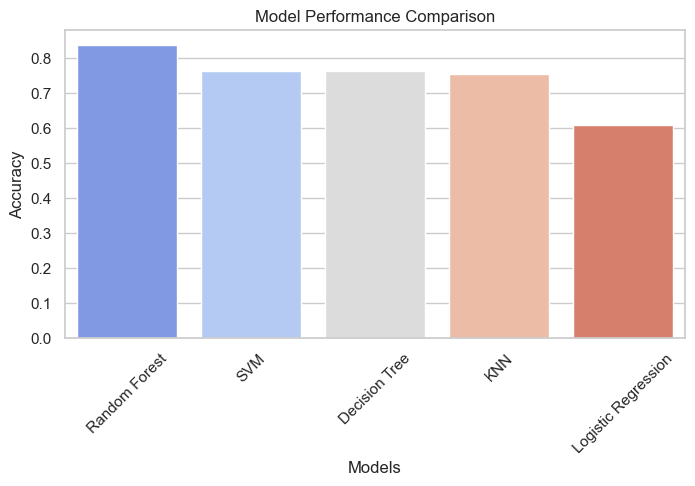

In [619]:
plt.figure(figsize=(8, 4))
sns.barplot(x=results_df.index, y=results_df['Accuracy'], palette="coolwarm")
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.show()

#### Testing

In [620]:
best_model = RandomForestClassifier()
best_model.fit(X_train_scaled, y_train)

# Input for testing
new_input = pd.DataFrame({
    'fixed acidity': [2.4],
    'volatile acidity': [0.2],
    'citric acid': [0.9],
    'residual sugar': [1.9],
    'chlorides': [0.076],
    'free sulfur dioxide': [41.0],
    'total sulfur dioxide': [34.0],
    'density': [0.9978],
    'pH': [1.51],
    'sulphates': [0.76],
    'alcohol': [9.4]
})

new_input_scaled = scaler.transform(new_input)

# Predict wine quality
predicted_quality = best_model.predict(new_input_scaled)
print(f"Predicted Wine Quality: {predicted_quality[0]}")

probabilities = best_model.predict_proba(new_input_scaled)
print(f"Class Probabilities: {probabilities}")

Predicted Wine Quality: 6
Class Probabilities: [[0.01 0.11 0.2  0.33 0.17 0.18]]


In the above code, I am taking a samples set of values for the explanatory features of a wine to classify its quality.
    
The class probabilities give the probabilities of the wine to have quality with values 3 to 8.

# Management Summary

Wine Quality Analysis Summary for Business Stakeholders

![Alt text](/Users/nitinnandansingh/Documents/workspace/Wine-Quality-Analysis/Assets/powerBI.jpg)

### Key Takeaways to Boost Wine Sales:
1. Critical Features Influencing Quality:
	* Positive Contributors:

		* Alcohol is the most significant positive factor for high-quality wine. Higher alcohol content typically correlates with better taste profiles.

		* Sulphates and citric acid enhance flavor and freshness, contributing positively to quality.

	* Negative Contributors:
		* Volatile acidity strongly reduces quality, often resulting in undesirable vinegar-like flavors. Efforts should focus on minimizing this element.

		* Total sulfur dioxide and density also negatively impact quality but to a lesser extent.
	
2. Predictive Modelling Insights:
	* Five machine learning models were tested to predict wine quality, with Random Forest achieving the best accuracy (around 85%). This suggests the ability to predict quality with high reliability using key wine properties.

	* A balanced dataset (using SMOTE) ensured fairness in model evaluation, addressing the initial imbalance in quality distribution.
		
3. PCA Insights (Dimensional Analysis):
	* The principal components highlighted that wines of higher quality typically have:
		* Lower volatile acidity.
		* Higher alcohol and citric acid levels.
		* Maintaining optimal levels of sulfur dioxide is also essential for good quality without exceeding permissible thresholds.
4. Descriptive Analysis Highlights:
	* Quality distribution revealed most wines are average (ratings 5 and 6). Increasing production of wines rated 7+ could significantly impact sales and brand reputation.
	* Boxplot analysis emphasized consistent patterns:
	* High-quality wines generally have balanced acidity and moderate chloride levels.
	* Sulphates and alcohol consistently rise in high-quality wines, reinforcing their importance in production.
5. Actionable Recommendations:
	* Product Development: Focus on enhancing alcohol and sulphate levels within safe and permissible limits.
	* Quality Control: Invest in techniques to reduce volatile acidity and optimize sulfur dioxide usage during production.
	* Marketing Strategies: Highlight key features such as “balanced acidity” and “aromatic stability” in high-quality wine lines to appeal to discerning customers.
6. Sales Support via Predictive Insights:
	* A predictive model is now available to estimate the quality of new wine batches based on their properties. This can help ensure only high-quality products reach the market, enhancing customer satisfaction and loyalty.

### **Future Steps for the Project**

To enhance the analysis and improve insights into wine quality, several future steps can be taken to refine the methodology, address data challenges, and explore advanced analytical techniques. Below are some recommended steps for the project:

#### **1. Data Enrichment**
- **Incorporate Additional Features**:  
  Include more detailed wine characteristics (e.g., region, grape(fruit) variety, fermentation process, weather conditions during harvest) to capture the complexities influencing wine quality.  
- **External Data Sources**:  
  Integrate external datasets, such as wine reviews, consumer preferences, or expert ratings, to provide a broader perspective on quality determination.



#### **2. Advanced Feature Engineering**
- **Non-linear Feature Transformations**:  
  Apply non-linear transformations (e.g., polynomial features, log transformations) to better capture relationships between variables.  
- **Interaction Features**:  
  Create interaction features to capture the combined effect of variables like acidity and alcohol content on quality.  
- **Dimensionality Reduction Techniques**:  
  Explore supervised dimensionality reduction techniques such as Linear Discriminant Analysis (LDA) for better class separation.


#### **3. Advanced Modeling**
- **Machine Learning Models**:  
  - Train advanced machine learning models (e.g. Neural Networks) for predictive modeling of wine quality. 



#### **4. Data Visualization and Insights**
- **Temporal and Geographic Analysis**:  
  Analyze trends over time or across regions to gain insights into how wine quality evolves under different environmental and production conditions.


#### **5. Model Deployment**
- **Real-Time Wine Quality Prediction**:  
  Deploy the best-performing model as a web application or API to allow winemakers or consumers to input wine characteristics and receive quality predictions.  
- **Cloud Integration**:  
  Use cloud platforms (e.g., AWS, GCP) to make the system scalable and accessible for larger datasets or more complex analyses.


By following these steps, the project can evolve into a comprehensive analysis of wine quality, bridging the gap between data science, winemaking, and consumer satisfaction.